This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Loading the IMDB dataset**

In [2]:
from tensorflow.keras.datasets import imdb
# Load the IMDB dataset with the top 10,000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Print the first review (as a sequence of integers)
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
#Print the first review's label (1 = positive, 0 = negative)
train_labels[0]

1

In [5]:
# Ensures all words are within the 10,000-word limit
max([max(sequence) for sequence in train_data])

9999

**Decoding reviews back to text**

In [6]:
# Get the word index dictionary mapping words to their assigned integer index
word_index = imdb.get_word_index()

# Reverse the word index to map integer indices back to words
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])

# Decode the first review:
# - IMDB dataset reserves the first 3 indices (0, 1, 2) for special tokens,
#   so we subtract 3 from each index when mapping it back to a word.
# - If a word index is not found, we replace it with "?"
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Preparing the data

**Encoding the integer sequences via multi-hot encoding**

In [7]:
import numpy as np

# Function to convert sequences of word indices into binary vector representations
def vectorize_sequences(sequences, dimension=10000):
    # Create a zero matrix of shape (number of samples, vocabulary size)
    results = np.zeros((len(sequences), dimension))

    # Set the corresponding index in the vector to 1 if the word is present in the review
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.  # Mark word presence as 1 (one-hot encoding)
    return results

# Vectorizing the training and testing data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
# Display the first vectorized review (binary representation of word presence)
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [10]:
# Convert the labels to a NumPy array of type float32
# - IMDB labels are originally in integer format (0 or 1)
# - Converting them to float32 ensures compatibility with neural network models
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

**Model definition**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# Defining a Sequential model
model = keras.Sequential([
    # First hidden layer with 16 neurons and ReLU activation
    layers.Dense(16, activation="relu"),

    # Second hidden layer with 16 neurons and ReLU activation
    layers.Dense(16, activation="relu"),

    # Output layer with 1 neuron and sigmoid activation
    # - Sigmoid is used to output a probability (since this is a binary classification problem)
    layers.Dense(1, activation="sigmoid")
])

**Compiling the model**

In [13]:
# Compile the model with the chosen optimizer, loss function, and evaluation metric
model.compile(optimizer="rmsprop", # RMSprop optimizer helps with adaptive learning rates
              loss="binary_crossentropy", # Binary cross-entropy is ideal for binary classification tasks
              metrics=["accuracy"]) # Track accuracy as the performance metric

### Validating your approach

**Setting aside a validation set**

In [15]:
# Splitting the training data into a validation set and a smaller training set

# First 10,000 samples for validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

# Remaining samples for training
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

In [16]:
# Training the model using the training data and validating on the validation set
history = model.fit(
    partial_x_train,       # Training data (excluding validation set)
    partial_y_train,       # Training labels
    epochs=20,             # Train for 20 epochs (full passes through the dataset)
    batch_size=512,        # Process 512 samples at a time (mini-batch gradient descent)
    validation_data=(x_val, y_val)  # Use validation data to monitor performance
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6945 - loss: 0.6074 - val_accuracy: 0.8661 - val_loss: 0.4131
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8923 - loss: 0.3592 - val_accuracy: 0.8706 - val_loss: 0.3403
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9157 - loss: 0.2656 - val_accuracy: 0.8926 - val_loss: 0.2860
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9333 - loss: 0.2091 - val_accuracy: 0.8897 - val_loss: 0.2776
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9512 - loss: 0.1628 - val_accuracy: 0.8889 - val_loss: 0.2771
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9599 - loss: 0.1365 - val_accuracy: 0.8863 - val_loss: 0.2844
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9664 - loss: 0.1167 - val_accuracy: 0.8862 - val_loss: 0.2934
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9726 - loss: 0.0998 - val_accuracy: 0.8782 - v

In [17]:
# Extracting the training history data
history_dict = history.history

# Displaying the available keys in the history dictionary
# The keys represent different metrics recorded during training
history_dict.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Plotting the training and validation loss**

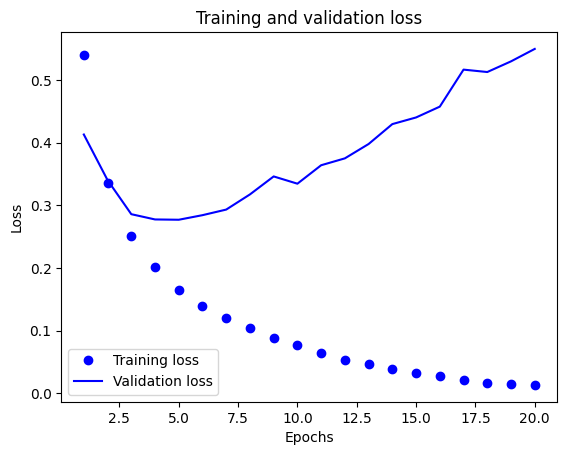

In [18]:
import matplotlib.pyplot as plt

# Extracting training history
history_dict = history.history

# Retrieving loss values for both training and validation sets
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Defining the range of epochs
epochs = range(1, len(loss_values) + 1)

# Plotting training loss
plt.plot(epochs, loss_values, "bo", label="Training loss")  # 'bo' = blue dots

# Plotting validation loss
plt.plot(epochs, val_loss_values, "b", label="Validation loss")  # 'b' = blue line

# Setting chart title and labels
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Displaying legend to differentiate training vs. validation loss
plt.legend()

# Showing the plot
plt.show()


**Plotting the training and validation accuracy**

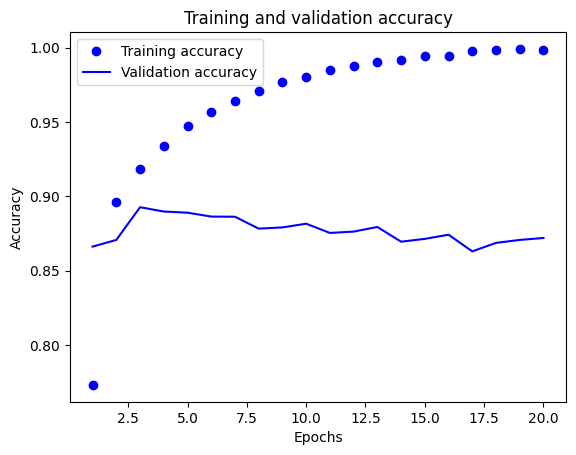

In [19]:
# Clearing the previous plot
plt.clf()

# Retrieving accuracy values for both training and validation sets
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

# Plotting training accuracy
plt.plot(epochs, acc, "bo", label="Training accuracy")  # 'bo' = blue dots

# Plotting validation accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy")  # 'b' = blue line

# Setting chart title and labels
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Displaying legend to differentiate training vs. validation accuracy
plt.legend()

# Showing the plot
plt.show()


**Retraining a model from scratch**

In [20]:
# Defining a Sequential neural network model
model = keras.Sequential([
    layers.Dense(16, activation="relu"),  # First hidden layer with 16 units and ReLU activation
    layers.Dense(16, activation="relu"),  # Second hidden layer with 16 units and ReLU activation
    layers.Dense(1, activation="sigmoid")  # Output layer with 1 unit and sigmoid activation for binary classification
])

# Compiling the model with optimizer, loss function, and evaluation metric
model.compile(optimizer="rmsprop",  # RMSprop optimizer for better performance
              loss="binary_crossentropy",  # Binary cross-entropy loss for classification
              metrics=["accuracy"])  # Accuracy as the evaluation metric

# Training the model on the full training dataset
model.fit(x_train, y_train, epochs=4, batch_size=512)  # Training for 4 epochs with a batch size of 512

# Evaluating the model on the test dataset
results = model.evaluate(x_test, y_test)  # Returns loss and accuracy on the test set


Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6981 - loss: 0.6021
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8958 - loss: 0.3167
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9194 - loss: 0.2262
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9360 - loss: 0.1834
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8841 - loss: 0.2903


In [21]:
results

[0.2875634431838989, 0.8862800002098083]

### Using a trained model to generate predictions on new data

In [22]:
# Generating predictions on the test dataset
# The model outputs probability scores (ranging from 0 to 1), representing the confidence level
# that a given review is positive.
model.predict(x_test)


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.18749622],
       [0.9999816 ],
       [0.9616977 ],
       ...,
       [0.1085952 ],
       [0.11427124],
       [0.6924363 ]], dtype=float32)

### Further experiments

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [23]:
# Importing the Reuters dataset from TensorFlow Keras
from tensorflow.keras.datasets import reuters

# Loading the Reuters dataset with the most frequent 10,000 words
# - train_data and test_data contain lists of word indices representing news articles.
# - train_labels and test_labels contain category labels for each article (integer-encoded).
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
# Getting the number of training samples (news articles) in the dataset
len(train_data)  # Returns the total number of training samples

8982

In [22]:
# Getting the number of test samples (news articles) in the dataset
len(test_data)  # Returns the total number of test samples

2246

In [25]:
# Displaying the 10th training sample
# The output will be a list of integers representing word indices in the Reuters dataset.
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

In [26]:
# Retrieving the word index dictionary for the Reuters dataset
# This dictionary maps words to their corresponding integer indices.
word_index = reuters.get_word_index()

# Reversing the word index to create a mapping from integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decoding the first news article in the training set
# - The dataset offsets word indices by 3 to reserve indices for special tokens.
# - Words not found in the dictionary are replaced with "?".
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])


550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Retrieving the label (topic category) of the 10th training sample
# The output will be an integer representing the category of the news article.
train_labels[10]


3

### Preparing the data

**Encoding the input data**

In [28]:
# Converting the training and test data into binary vector format
# Each sequence (news article) is represented as a vector of size 10,000,
# where each index is set to 1 if the corresponding word is present in the article.

x_train = vectorize_sequences(train_data)  # Vectorizing training data
x_test = vectorize_sequences(test_data)    # Vectorizing test data


**Encoding the labels**

In [29]:
# Function to convert labels into one-hot encoded format
# Since there are 46 different categories (news topics),
# each label is converted into a binary vector of size 46,
# where only the index corresponding to the label is set to 1.

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))  # Creating a zero matrix of shape (num_samples, 46)
    for i, label in enumerate(labels):
        results[i, label] = 1.  # Setting the corresponding index to 1
    return results

# One-hot encoding the training and test labels
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)


In [30]:
# Importing the built-in function to convert labels into one-hot encoded format
from tensorflow.keras.utils import to_categorical

# Using to_categorical to convert integer labels into one-hot encoded format
# This function automatically converts each label into a binary vector of size equal to the number of categories.
# In this case, since there are 46 categories (news topics), each label is transformed into a vector of size 46.

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)


### Building your model

**Model definition**

In [31]:
# Defining a neural network model using the Sequential API
model = keras.Sequential([
    # First hidden layer with 64 neurons and ReLU activation
    layers.Dense(64, activation="relu"),

    # Second hidden layer with 64 neurons and ReLU activation
    layers.Dense(64, activation="relu"),

    # Output layer with 46 neurons (one for each class) and softmax activation
    # Softmax ensures the output represents probabilities for each of the 46 categories.
    layers.Dense(46, activation="softmax")
])


**Compiling the model**

In [32]:
# Compiling the model with the following configurations:
model.compile(
    optimizer="rmsprop",  # Using RMSprop optimizer for efficient gradient updates
    loss="categorical_crossentropy",  # Suitable loss function for multi-class classification
    metrics=["accuracy"]  # Tracking accuracy as a performance metric
)


### Validating your approach

**Setting aside a validation set**

In [33]:
# Splitting the training data into a validation set and a smaller training set
x_val = x_train[:1000]  # First 1000 samples for validation
partial_x_train = x_train[1000:]  # Remaining samples for training

y_val = y_train[:1000]  # First 1000 labels for validation
partial_y_train = y_train[1000:]  # Remaining labels for training


**Training the model**

In [34]:
# Training the model with the training data and validating on the validation set
history = model.fit(
    partial_x_train,  # Training data (excluding validation set)
    partial_y_train,  # Training labels
    epochs=20,  # Number of times the model will see the entire dataset
    batch_size=512,  # Number of samples per gradient update
    validation_data=(x_val, y_val)  # Validation set to monitor overfitting
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4154 - loss: 3.2129 - val_accuracy: 0.6130 - val_loss: 1.8714
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6568 - loss: 1.6547 - val_accuracy: 0.6890 - val_loss: 1.4250
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7174 - loss: 1.2685 - val_accuracy: 0.7300 - val_loss: 1.2346
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7739 - loss: 1.0220 - val_accuracy: 0.7510 - val_loss: 1.1164
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8065 - loss: 0.8757 - val_accuracy: 0.7810 - val_loss: 1.0329
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8370 - loss: 0.7500 - val_accuracy: 0.7950 - val_loss: 0.9970
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8739 - loss: 0.5988 - val_accuracy: 0.7950 - val_loss: 0.9432
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8989 - loss: 0.4842 - val_accuracy: 0.8170 - v

**Plotting the training and validation loss**

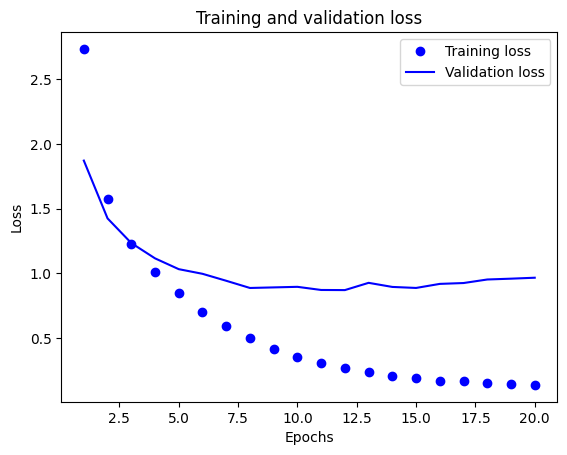

In [35]:
# Plotting the training and validation loss to analyze model performance
loss = history.history["loss"]  # Training loss values for each epoch
val_loss = history.history["val_loss"]  # Validation loss values for each epoch
epochs = range(1, len(loss) + 1)  # Creating a range for the number of epochs

plt.plot(epochs, loss, "bo", label="Training loss")  # Plot training loss with blue dots
plt.plot(epochs, val_loss, "b", label="Validation loss")  # Plot validation loss with a solid blue line
plt.title("Training and validation loss")  # Title of the plot
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.legend()  # Show legend
plt.show()  # Display the plot


**Plotting the training and validation accuracy**

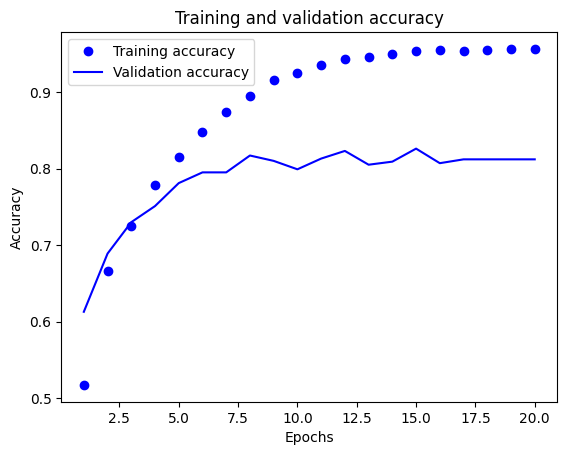

In [36]:
# Clearing the current figure to avoid overlapping plots
plt.clf()

# Extracting accuracy values from training history
acc = history.history["accuracy"]  # Training accuracy values for each epoch
val_acc = history.history["val_accuracy"]  # Validation accuracy values for each epoch

# Plotting the training and validation accuracy
plt.plot(epochs, acc, "bo", label="Training accuracy")  # Blue dots for training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy")  # Solid blue line for validation accuracy

# Adding labels and title
plt.title("Training and validation accuracy")  # Title of the plot
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Display the legend
plt.show()  # Display the plot


**Retraining a model from scratch**

In [37]:
# Defining the neural network model
model = keras.Sequential([
    layers.Dense(64, activation="relu"),  # First hidden layer with 64 neurons and ReLU activation
    layers.Dense(64, activation="relu"),  # Second hidden layer with 64 neurons and ReLU activation
    layers.Dense(46, activation="softmax")  # Output layer with 46 neurons (one per class) and softmax activation for multi-class classification
])

# Compiling the model with the RMSprop optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",  # Suitable for multi-class classification
              metrics=["accuracy"])  # Track accuracy during training

# Training the model using the full training dataset
model.fit(x_train,
          y_train,
          epochs=9,  # Training for 9 epochs
          batch_size=512)  # Using a batch size of 512 for efficient training

# Evaluating the model's performance on the test dataset
results = model.evaluate(x_test, y_test)  # Returns loss and accuracy on test data


Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3987 - loss: 3.1009
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6666 - loss: 1.5348
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7534 - loss: 1.1290
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7936 - loss: 0.9576
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8302 - loss: 0.7710
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8580 - loss: 0.6319
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8889 - loss: 0.5246
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9041 - loss: 0.4501
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9219 - loss: 0.3733
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7969 - loss: 0.8968


In [36]:
results

[0.9323733448982239, 0.7880676984786987]

In [38]:
import copy
test_labels_copy = copy.copy(test_labels)  # Creating a copy of the test labels to avoid modifying the original data
np.random.shuffle(test_labels_copy)  # Shuffling the copied test labels randomly

# Comparing the shuffled labels with the original test labels
hits_array = np.array(test_labels) == np.array(test_labels_copy)

# Calculating the mean, which represents the proportion of labels that remained in the same position after shuffling
hits_array.mean()


0.19323241317898487

### Generating predictions on new data

In [39]:
predictions = model.predict(x_test)  # Generating predictions for the test dataset

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [39]:
predictions[0].shape  # Checking the shape of the prediction for the first test sample

(46,)

In [40]:
np.sum(predictions[0])  # Verifying that the sum of probabilities for the first test sample is 1

0.9999998

In [41]:
np.argmax(predictions[0])  # Identifying the class with the highest probability for the first test sample

3

### A different way to handle the labels and the loss

In [42]:
y_train = np.array(train_labels)  # Converting training labels to a NumPy array for efficient processing
y_test = np.array(test_labels)    # Converting test labels to a NumPy array for consistency in model input

In [43]:
# Compile the model with RMSprop optimizer and sparse categorical cross-entropy loss
model.compile(optimizer="rmsprop",  # RMSprop optimizer helps with adaptive learning rates
              loss="sparse_categorical_crossentropy",  # Suitable for integer-labeled multi-class classification
              metrics=["accuracy"])  # Tracks accuracy during training and evaluation

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

# Define a Sequential model with three dense layers
model = keras.Sequential([
    layers.Dense(64, activation="relu"),  # First hidden layer with 64 neurons and ReLU activation
    layers.Dense(4, activation="relu"),   # Second hidden layer with only 4 neurons (may cause underfitting)
    layers.Dense(46, activation="softmax")  # Output layer with 46 neurons (one for each class), using softmax activation
])

# Compile the model with RMSprop optimizer and categorical cross-entropy loss
model.compile(optimizer="rmsprop",  # RMSprop optimizer for adaptive learning rates
              loss="categorical_crossentropy",  # Suitable for multi-class classification with one-hot encoded labels
              metrics=["accuracy"])  # Accuracy as the evaluation metric

# Train the model using partial training data and validate on validation set
history = model.fit(partial_x_train,  # Training input data
                    partial_y_train,  # Training labels
                    epochs=20,  # Train for 20 epochs
                    batch_size=128,  # Process data in batches of 128
                    validation_data=(x_val, y_val))  # Use validation set for performance tracking


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0513 - loss: 3.5753 - val_accuracy: 0.2570 - val_loss: 2.8668
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2810 - loss: 2.5743 - val_accuracy: 0.5830 - val_loss: 1.7891
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6011 - loss: 1.5339 - val_accuracy: 0.6320 - val_loss: 1.4112
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6860 - loss: 1.2433 - val_accuracy: 0.6910 - val_loss: 1.3336
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7488 - loss: 1.0483 - val_accuracy: 0.6940 - val_loss: 1.2913
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7765 - loss: 0.9507 - val_accuracy: 0.7070 - val_loss: 1.2739
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7859 - loss: 0.8964 - val_accuracy: 0.7120 - val_loss: 1.2732
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7993 - loss: 0.8164 - val_accuracy: 0.7210 - v

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [45]:
from tensorflow.keras.datasets import boston_housing

# Load the Boston Housing dataset
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
train_data.shape

(404, 13)

In [47]:
test_data.shape

(102, 13)

In [48]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [49]:
mean = train_data.mean(axis=0)  # Compute the mean of each feature (column-wise)
train_data -= mean  # Subtract the mean from each feature
std = train_data.std(axis=0)  # Compute the standard deviation of each feature
train_data /= std  # Divide each feature by its standard deviation

# Apply the same mean and std from training data to test data
test_data -= mean
test_data /= std


### Building your model

**Model definition**

In [50]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),  # First hidden layer with 64 neurons and ReLU activation
        layers.Dense(64, activation="relu"),  # Second hidden layer with 64 neurons and ReLU activation
        layers.Dense(1)  # Output layer with 1 neuron (predicting a continuous value)
    ])
    model.compile(
        optimizer="rmsprop",  # RMSprop optimizer for adaptive learning rate
        loss="mse",  # Mean Squared Error (MSE) as loss function (suitable for regression)
        metrics=["mae"]  # Mean Absolute Error (MAE) as an additional metric
    )
    return model  # Returns the compiled model


### Validating your approach using K-fold validation

**K-fold validation**

In [51]:
# Number of folds for cross-validation
k = 4

# Number of validation samples per fold
num_val_samples = len(train_data) // k

# Number of training epochs per fold
num_epochs = 100

# List to store validation Mean Absolute Error (MAE) scores
all_scores = []

# Loop through each fold
for i in range(k):
    print(f"Processing fold #{i}")  # Indicate which fold is being processed

    # Select the validation data for the current fold
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Select the training data by excluding the validation fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],  # Data before the validation set
         train_data[(i + 1) * num_val_samples:]],  # Data after the validation set
        axis=0)

    # Select the training targets by excluding the validation fold
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],  # Targets before the validation set
         train_targets[(i + 1) * num_val_samples:]],  # Targets after the validation set
        axis=0)

    # Build a fresh model for this fold
    model = build_model()

    # Train the model on the training data (excluding the validation fold)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)  # Silent training

    # Evaluate the model on the validation set
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  # Get MSE and MAE

    # Store the validation MAE for this fold
    all_scores.append(val_mae)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [52]:
all_scores

[1.9762396812438965, 2.310173988342285, 2.6596169471740723, 2.445335865020752]

In [53]:
np.mean(all_scores)

2.3478416204452515

**Saving the validation logs at each fold**

In [54]:
# Set the number of epochs for training
num_epochs = 500

# List to store validation MAE history for each fold
all_mae_histories = []

# Loop through each fold in k-fold cross-validation
for i in range(k):
    print(f"Processing fold #{i}")  # Indicate which fold is being processed

    # Select the validation data for the current fold
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Select the training data by excluding the validation fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],  # Data before the validation set
         train_data[(i + 1) * num_val_samples:]],  # Data after the validation set
        axis=0)

    # Select the training targets by excluding the validation fold
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],  # Targets before the validation set
         train_targets[(i + 1) * num_val_samples:]],  # Targets after the validation set
        axis=0)

    # Build a fresh model for this fold
    model = build_model()

    # Train the model and store training history
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),  # Use current fold as validation data
                        epochs=num_epochs, batch_size=16, verbose=0)  # Silent training

    # Extract validation MAE history for all epochs
    mae_history = history.history["val_mae"]

    # Store the validation MAE history for this fold
    all_mae_histories.append(mae_history)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [57]:
# Compute the average validation MAE at each epoch across all k folds
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] # Iterate over all epochs

**Plotting validation scores**

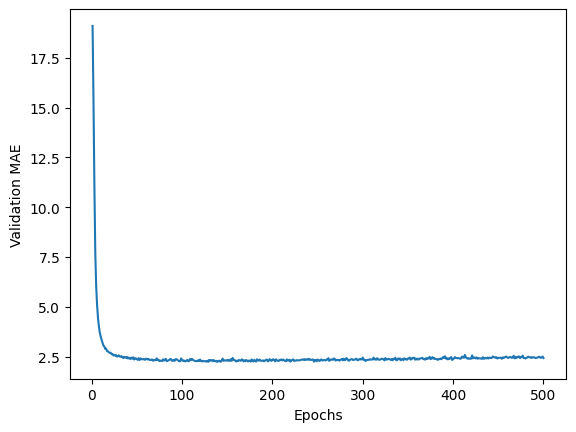

In [58]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Plot the validation MAE over epochs
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)  # X-axis: Epochs, Y-axis: Average validation MAE

# Label the X-axis as 'Epochs'
plt.xlabel("Epochs")

# Label the Y-axis as 'Validation MAE'
plt.ylabel("Validation MAE")

# Display the plot
plt.show()


**Plotting validation scores, excluding the first 10 data points**

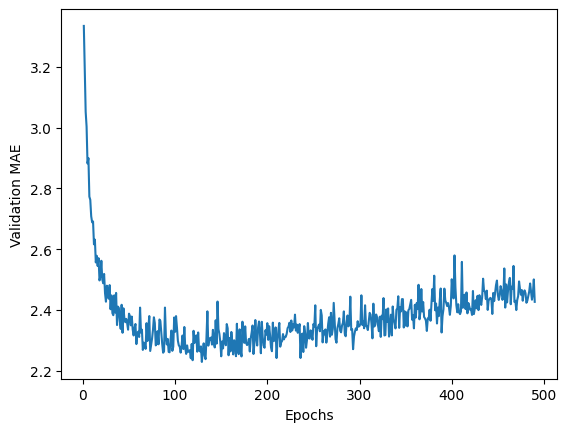

In [59]:
# Remove the first 10 data points to reduce noise and focus on later epochs
truncated_mae_history = average_mae_history[10:]

# Plot the truncated validation MAE over epochs
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)

# Label the X-axis as 'Epochs'
plt.xlabel("Epochs")

# Label the Y-axis as 'Validation MAE'
plt.ylabel("Validation MAE")

# Display the plot
plt.show()


**Training the final model**

In [60]:
# Build a new instance of the model
model = build_model()

# Train the model using the entire training dataset
# - Epochs: 130 (train for 130 iterations over the dataset)
# - Batch size: 16 (process 16 samples at a time)
# - Verbose: 0 (suppress output during training)
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)

# Evaluate the trained model on the test dataset
# - Returns Mean Squared Error (MSE) and Mean Absolute Error (MAE)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.3895 - mae: 2.2797 


In [61]:
test_mae_score

2.489670991897583

### Generating predictions on new data

In [61]:
# Generate predictions on the test dataset
predictions = model.predict(test_data)

# Display the first predicted value
predictions[0]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([9.597569], dtype=float32)

### Wrapping up

## Summary